In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn import manifold
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, preprocessing as kpreprocessing
from tensorflow.keras import backend as K

from gensim.models import Word2Vec
from gensim.models.phrases import Phraser
from gensim.models.phrases import Phrases

In [2]:
DATA_PATH = "../data/train_preprocessed.pkl"
RANDOM_STATE = 42

In [3]:
tf.random.set_seed(
    RANDOM_STATE
)

In [4]:
df = pd.read_pickle(DATA_PATH)
df.head()

,text,class,spacy,lemmatized,stemmed,lemmatized_stopwords,stemmed_stopwords
0,проблема: не открывается АКТ сверки по СБС № П...,1-46,"(проблема, :, не, открывается, АКТ, сверки, по...",проблема не открываться акт сверка по сбс паке...,проблем не открыва акт сверк по сбс пакет доку...,открываться акт сверка сбс пакет документ скан...,открыва акт сверк сбс пакет документ скан прилага
1,В случае выбора неверного шаблона просьба указ...,1-70,"(В, случае, выбора, неверного, шаблона, просьб...",в случай выбор неверный шаблон просьба указать...,в случа выбор неверн шаблон просьб указа наиме...,в случай выбор неверный шаблон указать наимено...,в случа выбор неверн шаблон указа наименован к...
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11,"(Вопрос, /, информация, Добрый, день, !, В, ЗН...",вопрос информация добрый день в знв в графа су...,вопрос информац добр ден в знв в граф сумм ком...,вопрос информация добрый в знв графа сумма ком...,вопрос информац добр в знв граф сумм комисс от...
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1,"(Вопрос, /, проблема, :, После, выхода, из, от...",вопрос проблема после выход из отпуск с меню в...,вопрос проблем посл выход из отпуск с мен в sa...,вопрос после выход отпуск меню sap увхд стать ...,вопрос посл выход отпуск мен sap увхд стат кор...
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28,"(В, УВХД, необходимо, снять, резервирование, с...",в увхд необходимый снять резервирование с знс ...,в увхд необходим снят резервирован с знс не да...,в увхд снять резервирование знс давать постави...,в увхд снят резервирован знс дава постав стату...


In [5]:
df_train, df_test, y_train, y_test = train_test_split(
    df['lemmatized'], df['class'], test_size=0.2, random_state=RANDOM_STATE
)

In [6]:
corpus = df_train

lst_corpus = []
for string in corpus:
    lst_words = string.split(' ')
    lst_grams = [' '.join(lst_words[i:i+1]) for i in range(len(lst_words))]
    lst_corpus.append(lst_grams)

bigrams_detector = Phrases(lst_corpus, min_count=5, threshold=10)
bigrams_detector = Phraser(bigrams_detector)

trigrams_detector = Phrases(bigrams_detector[lst_corpus], min_count=5, threshold=10)
trigrams_detector = Phraser(trigrams_detector)

In [7]:
w2v = Word2Vec(lst_corpus, window=8)

In [8]:
w2v.wv['проблема'].shape

(100,)

In [10]:
tokenizer = kpreprocessing.text.Tokenizer(lower=True, split=' ', oov_token='NaN')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

lst_texxt2seq = tokenizer.texts_to_sequences(lst_corpus)

X_train = kpreprocessing.sequence.pad_sequences(lst_texxt2seq, maxlen=30, padding='post',
                                                truncating='post')

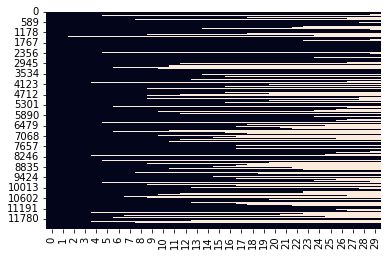

In [11]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False);

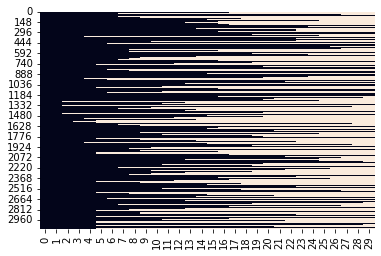

In [12]:
corpus = df_test

lst_corpus = []
for string in corpus:
    lst_words = string.split(' ')
    lst_grams = [' '.join(lst_words[i:i+1]) for i in range(len(lst_words))]
    lst_corpus.append(lst_grams)

lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])

lst_texxt2seq = tokenizer.texts_to_sequences(lst_corpus)

X_test = kpreprocessing.sequence.pad_sequences(lst_texxt2seq, maxlen=30, padding='post', truncating='post')

sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False);

In [13]:
X_train.shape

(12359, 30)

In [14]:
embeddings = np.zeros((len(dic_vocabulary) + 1, 100))

for word, idx in dic_vocabulary.items():
    try:
        embeddings[idx] = w2v.wv[word]
    except:
        pass

In [15]:
## code attention layer
shape = 30

def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(shape,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=shape, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=shape)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=shape, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=shape, dropout=0.2))(x)
## final dense layers
x = layers.Dense(90, activation='relu')(x)
y_out = layers.Dense(df['class'].unique().shape[0], activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      1554100     ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 100, 30)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 100, 30)      930         ['permute[0][0]']                
                                                                                              

In [16]:
## encode y
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

In [17]:
%%time
## train
training = model.fit(x=X_train, y=y_train, batch_size=32,
                     epochs=10, shuffle=True, verbose=True, 
                     validation_split=0.25)

Epoch 1/10
145/145 [==============================] - 79s 485ms/step - loss: 3.8801 - accuracy: 0.1226 - val_loss: 3.4157 - val_accuracy: 0.1867
Epoch 2/10
145/145 [==============================] - 68s 467ms/step - loss: 3.0897 - accuracy: 0.2193 - val_loss: 2.7878 - val_accuracy: 0.2670
Epoch 3/10
145/145 [==============================] - 68s 467ms/step - loss: 2.6458 - accuracy: 0.2788 - val_loss: 2.5308 - val_accuracy: 0.3152
Epoch 4/10
145/145 [==============================] - 67s 463ms/step - loss: 2.4472 - accuracy: 0.3294 - val_loss: 2.3445 - val_accuracy: 0.3599
Epoch 5/10
145/145 [==============================] - 67s 464ms/step - loss: 2.2889 - accuracy: 0.3614 - val_loss: 2.2362 - val_accuracy: 0.3693
Epoch 6/10
145/145 [==============================] - 67s 465ms/step - loss: 2.1747 - accuracy: 0.3864 - val_loss: 2.1442 - val_accuracy: 0.3994
Epoch 7/10
145/145 [==============================] - 67s 465ms/step - loss: 2.0877 - accuracy: 0.4075 - val_loss: 2.1125 - val_ac

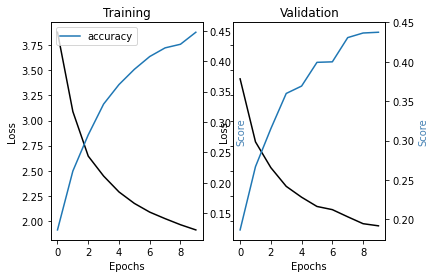

In [18]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [19]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [26]:
from sklearn.metrics import f1_score, accuracy_score

print(accuracy_score(y_test, predicted))
print(f1_score(y_test, predicted, average='weighted'))

0.2993527508090615
0.26840569395618735
